# QFIE For Fan Speed Control

This notebook aims to illustrate how QFIE can control efficiently the speed of a Fan according to the input variables 'Core Temperature' and 'Clock Speed'. Finally, the control surface of the system will be obtained both using QFIE and the canonical Mamdani fuzzy system, which configuration is reported in the paper.  

Firstly, let us import the required libraries.

In [1]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import FuzzyEngines as FE



end


The system is a MISO composed of two input variables and one output variable. For each of them three fuzzy sets are considered.

- For core temperature the fuzzy sets used are releted to the linguistic terms: 'cold', 'warm' and 'hot'.

- For clock speed the fuzzy sets are related to the linguistic terms: 'low', 'normal' and 'turbo'

- For the output variable, named 'Fan Speed' two fuzzy sets are used related to the linguistic terms: 'slow' and 'fast

By running the following cell, the fuzzy sets used are graphically shown. 

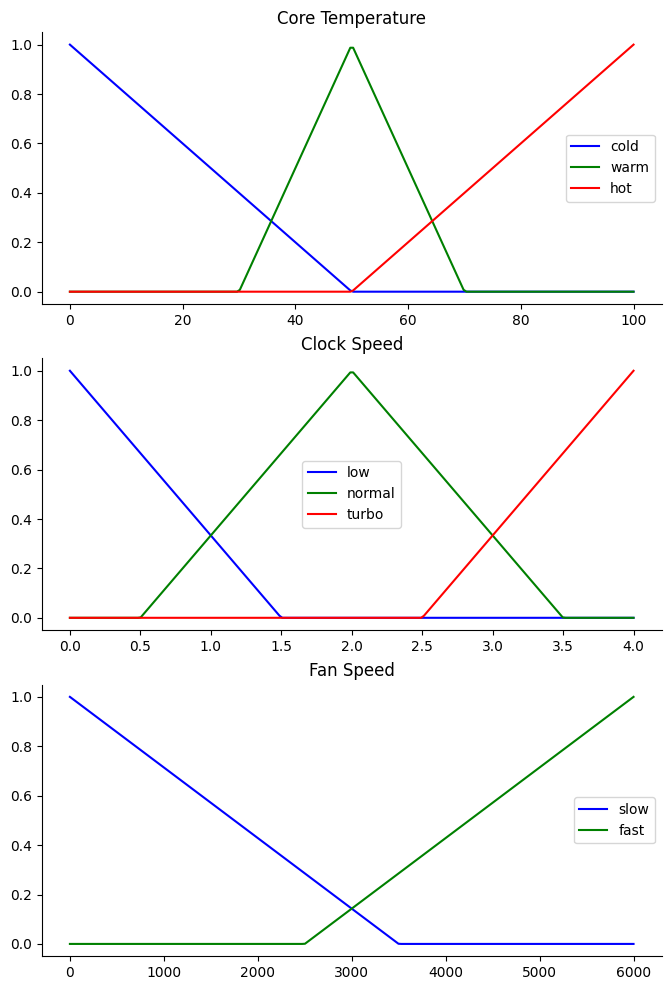

In [2]:

core_temperature = np.linspace(0, 100, 200)
clock_speed = np.linspace(0, 4, 200)
fan_speed = np.linspace(0, 6000, 200)



t_cold = fuzz.trimf(core_temperature, [0,0,50])
t_warm = fuzz.trimf(core_temperature, [30,50,70])
t_hot = fuzz.trimf(core_temperature, [50, 100, 100])

cs_low = fuzz.trimf(clock_speed, [0,0,1.5])
cs_normal = fuzz.trimf(clock_speed, [0.5,2,3.5])
cs_turbo = fuzz.trimf(clock_speed, [2.5,4,4])

fs_slow = fuzz.trimf(fan_speed, [0, 0, 3500])
fs_fast = fuzz.trimf(fan_speed, [2500, 6000, 6000])

# Visualize these universes and membership functions
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 12))


ax0.plot(core_temperature, t_cold, 'b', linewidth=1.5, label='cold')
ax0.plot(core_temperature, t_warm, 'g', linewidth=1.5, label='warm')
ax0.plot(core_temperature, t_hot, 'r', linewidth=1.5, label='hot')
ax0.set_title('Core Temperature')
ax0.legend()

ax1.plot(clock_speed, cs_low, 'b', linewidth=1.5, label='low')
ax1.plot(clock_speed, cs_normal, 'g', linewidth=1.5, label='normal')
ax1.plot(clock_speed, cs_turbo, 'r', linewidth=1.5, label='turbo')
ax1.set_title('Clock Speed')
ax1.legend()


ax2.plot(fan_speed, fs_slow, 'b', linewidth=1.5, label='slow')
ax2.plot(fan_speed, fs_fast, 'g', linewidth=1.5, label='fast')
ax2.set_title('Fan Speed')
ax2.legend()

# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()


plt.show()

The rules base of the system is composed of the following rules: 

- if temp is cold and clock is low then fan is slow
- if temp is cold and clock is normal then fan is slow'
- if temp is cold and clock is turbo then fan is fast'
- if temp is warm and clock is low then fan is slow'
- if temp is warm and clock is normal then fan is slow'
- if temp is warm and clock is turbo then fan is fast'
- if temp is hot and clock is low then fan is fast'
- if temp is hot and clock is normal then fan is fast'
- if temp is hot and clock is turbo then fan is fast'

By running the following two cells QFIE is properly initialized


In [3]:
rules = ['if temp is cold and clock is low then fan is slow',
         'if temp is cold and clock is normal then fan is slow',
         'if temp is cold and clock is turbo then fan is fast',
         'if temp is warm and clock is low then fan is slow',
         'if temp is warm and clock is normal then fan is slow',
         'if temp is warm and clock is turbo then fan is fast',
         'if temp is hot and clock is low then fan is fast',
         'if temp is hot and clock is normal then fan is fast',
         'if temp is hot and clock is turbo then fan is fast']


In [4]:
qfie_linear = FE.QuantumFuzzyEngine(verbose=True, encoding='linear')

qfie_linear.input_variable(name='temp', range=core_temperature)
qfie_linear.input_variable(name='clock', range=clock_speed)
qfie_linear.output_variable(name='fan', range=fan_speed)

qfie_linear.add_input_fuzzysets(var_name='temp', set_names=['cold', 'warm', 'hot'], sets=[t_cold, t_warm, t_hot])
qfie_linear.add_input_fuzzysets(var_name='clock', set_names=['low', 'normal', 'turbo'], sets=[cs_low, cs_normal, cs_turbo])
qfie_linear.add_output_fuzzysets(var_name='fan', set_names=['slow', 'fast'],sets=[fs_slow,fs_fast])
qfie_linear.set_rules(rules)

qfie_log = FE.QuantumFuzzyEngine(verbose=True, encoding='logaritmic')

qfie_log.input_variable(name='temp', range=core_temperature)
qfie_log.input_variable(name='clock', range=clock_speed)
qfie_log.output_variable(name='fan', range=fan_speed)

qfie_log.add_input_fuzzysets(var_name='temp', set_names=['cold', 'warm', 'hot'], sets=[t_cold, t_warm, t_hot])
qfie_log.add_input_fuzzysets(var_name='clock', set_names=['low', 'normal', 'turbo'], sets=[cs_low, cs_normal, cs_turbo])
qfie_log.add_output_fuzzysets(var_name='fan', set_names=['slow', 'fast'],sets=[fs_slow,fs_fast])
qfie_log.set_rules(rules)

To obtain the control surface of QFIE, it is used to fire the rules in 100 different input combinations. In detail, for 10 values of temperature, 10 different values of clock speed are considered. The 100 outputs obtained are collected in a list which will be used at the end of the notebook to plot the control surface. 

In [5]:
from qiskit_ibm_runtime.fake_provider import FakeMumbaiV2
temp_list, speed_list = [t for t in range(0, 100, 10)], [s/2.5 for s in range(0, 10, 1)]
f_quantum_linear, f_quantum_log= [], []
for t in temp_list:
    for s in speed_list:
        qfie_linear.build_inference_qc({'temp':t, 'clock':s}, distributed=False, draw_qc=True, filename='./linear.png')
        qfie_log.build_inference_qc({'temp':t, 'clock':s}, distributed=False, draw_qc=True, filename='./log.png')
        f_quantum_linear.append(qfie_linear.execute(5000, backend=FakeMumbaiV2(), plot_histo=False, transpile_info=True)[0])
        f_quantum_log.append(qfie_log.execute(5000, backend=FakeMumbaiV2(), plot_histo=False, transpile_info=True)[0])


{'temp': 0, 'clock': 0.0}
Input values  {'temp': [np.float64(1.0), np.float64(0.0), np.float64(0.0)], 'clock': [np.float64(1.0), np.float64(0.0), np.float64(0.0)]}
draw
{'temp': 0, 'clock': 0.0}
Input values  {'temp': [np.float64(1.0), np.float64(0.0), np.float64(0.0)], 'clock': [np.float64(1.0), np.float64(0.0), np.float64(0.0)]}
draw
Running qc full_circuit on fake_mumbai
debug 3
transpiled depth qc full_circuit 209
Operations full_circuit OrderedDict([('rz', 137), ('cx', 114), ('sx', 65), ('barrier', 9), ('reset', 6), ('measure', 2), ('x', 1)])
Output Counts {'01': 0.7852, '10': 0.0744}
Running qc full_circuit on fake_mumbai
debug 3
transpiled depth qc full_circuit 1021
Operations full_circuit OrderedDict([('cx', 637), ('rz', 522), ('sx', 154), ('x', 44), ('barrier', 9), ('reset', 4), ('measure', 2)])
Output Counts {'01': 0.4707, '10': 0.3073}
{'temp': 0, 'clock': 0.4}
Input values  {'temp': [np.float64(1.0), np.float64(0.0), np.float64(0.0)], 'clock': [np.float64(0.7333333333333334

____
Then, the classical Mamdani system is implemented by using the python library Sci-kit Fuzzy. The following cells initializes the system as required from the library.  

In [6]:
from skfuzzy import control as ctrl

In [7]:
temp = ctrl.Antecedent(core_temperature, 'temp')
speed = ctrl.Antecedent(clock_speed , 'speed')
fan = ctrl.Consequent(fan_speed, 'fan')

temp['cold'] = t_cold
temp['warm'] = t_warm
temp['hot'] = t_hot 

speed['low'] = cs_low
speed['normal'] = cs_normal
speed['turbo'] = cs_turbo 

fan['slow'] = fs_slow
fan['fast'] = fs_fast

rule1 = ctrl.Rule(temp['cold'] & speed['low'], fan['slow'])
rule2 = ctrl.Rule(temp['cold'] & speed['normal'], fan['slow'])
rule3 = ctrl.Rule(temp['cold'] & speed['turbo'], fan['fast'])
rule4 = ctrl.Rule(temp['warm'] & speed['low'], fan['slow'])
rule5 = ctrl.Rule(temp['warm'] & speed['normal'], fan['slow'])
rule6 = ctrl.Rule(temp['warm'] & speed['turbo'], fan['fast'])
rule7 = ctrl.Rule(temp['hot'] & speed['low'], fan['fast'])
rule8 = ctrl.Rule(temp['hot'] & speed['normal'], fan['fast'])
rule9 = ctrl.Rule(temp['hot'] & speed['turbo'], fan['fast'])

fan_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
fan_sys = ctrl.ControlSystemSimulation(fan_ctrl)





By running the following cell, the same combinations of inputs are passed to the classical control which computes the 100 output. All the output values are stored in a list. 

In [8]:
f_classical = []
for t in temp_list:
    for s in speed_list:
        fan_sys.input['temp']=t    
        fan_sys.input['speed']=s

        fan_sys.compute()
        f_classical.append(fan_sys.output['fan'])

At this point, both the QFIE and Classical system' control surfaces can be plotted. Firstly, the following cell shows the former surface. 

Text(0.5, 0, 'Fan Speed')

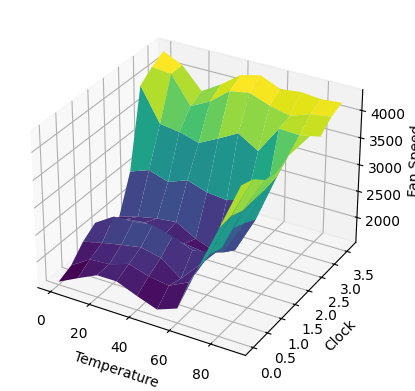

In [9]:
from mpl_toolkits.mplot3d import Axes3D

X, Y, = temp_list, speed_list
plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),10), np.linspace(np.min(Y),np.max(Y),10))
Z = np.zeros_like(plotx)
counter = 0 
for i in range(len(temp_list)):
    for j in range(len(speed_list)):
        Z[i,j]=f_quantum_linear[counter]
        counter+=1
        
zfig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(plotx, ploty, Z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)
ax.set_xlabel('Temperature')
ax.set_ylabel('Clock')
ax.set_zlabel('Fan Speed')


Then, the classical surface is displayed by running the following cell. 

Text(0.5, 0, 'Fan Speed')

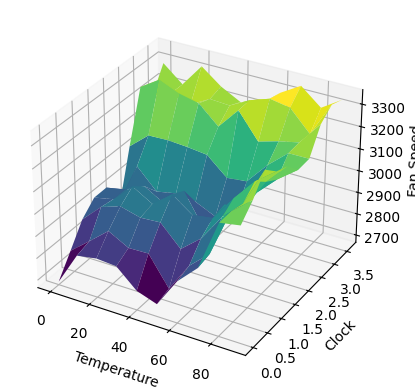

In [10]:
X, Y, = temp_list, speed_list
plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),10), np.linspace(np.min(Y),np.max(Y),10))
Z = np.zeros_like(plotx)
counter = 0 
for i in range(len(temp_list)):
    for j in range(len(speed_list)):
        Z[i,j]=f_quantum_log[counter]
        counter+=1
        
zfig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(plotx, ploty, Z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)
ax.set_xlabel('Temperature')
ax.set_ylabel('Clock')
ax.set_zlabel('Fan Speed')

Text(0.5, 0, 'Fan Speed')

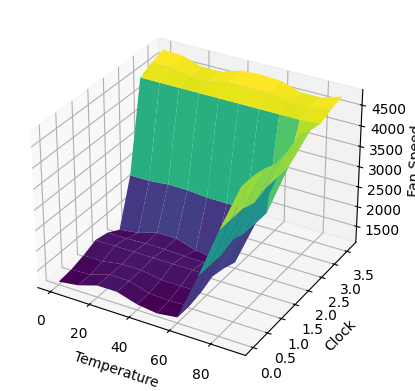

In [11]:
X, Y, = temp_list, speed_list
plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),10), np.linspace(np.min(Y),np.max(Y),10))
Z = np.zeros_like(plotx)
counter = 0 
for i in range(len(temp_list)):
    for j in range(len(speed_list)):
        Z[i,j]=f_classical[counter]
        counter+=1
zfig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(plotx, ploty, Z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)
ax.set_xlabel('Temperature')
ax.set_ylabel('Clock')
ax.set_zlabel('Fan Speed')



The two surfaces show how QFIE is able to control in a very similar way to a classical Mamdani fuzzy control the Fan Speed system, despite the computational advantage in firing the fuzzy rules in a parallel way.

In [12]:
from qiskit import QuantumCircuit
import math
from qiskit.quantum_info import Statevector

qc = QuantumCircuit(3)
qc.initialize([math.sqrt(0.5),0,0,0,math.sqrt(0.5),0,0,0])
Statevector(qc).probabilities_dict()


{np.str_('000'): np.float64(0.5000000000000001),
 np.str_('100'): np.float64(0.5000000000000001)}